In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

x = np.arange(-10, 10, 0.1)

## Distortion
### nonlinear transfer functions

#### from DAFX book
See https://dsp.stackexchange.com/questions/13142/digital-distortion-effect-algorithm

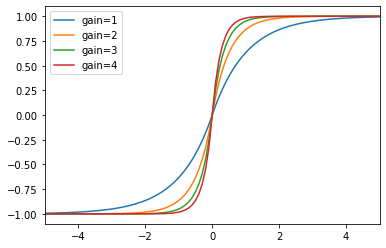

In [34]:
def distortion_dafx(x, gain=1):
    y = x * gain
    return (y / np.absolute(y)) * (1-np.exp(-1*np.absolute(y)))

for i in [1, 2, 3, 4]:
    plt.plot(x, distortion_dafx(x, gain=i), label='gain={}'.format(i))
plt.xlim(-5, 5)
plt.legend()

#### tanh

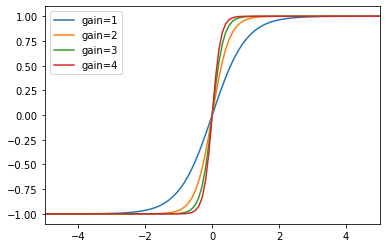

In [33]:
def tanh_alt(x, gain=1):
    y = x * gain
    return 2 / (1 + np.exp(-2*y)) - 1

#plt.plot(x, np.tanh(x), x, tanh_alt(x))
for i in [1, 2, 3, 4]:
    plt.plot(x, tanh_alt(x, gain=i), label='gain={}'.format(i))
plt.xlim(-5, 5)
plt.legend()

#### sigmoid

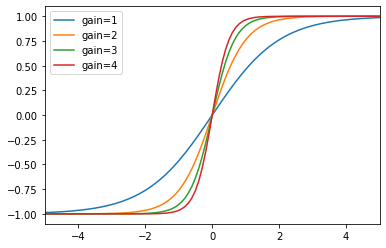

In [32]:
def sigmoid_bipolar(x, gain=1):
    y = x * gain
    return (1 - np.exp(-y)) / (1 + np.exp(-y))

for i in [1, 2, 3, 4]:
    plt.plot(x, sigmoid_bipolar(x, gain=i), label='gain={}'.format(i))
plt.xlim(-5, 5)
plt.legend()

#### hard clipping

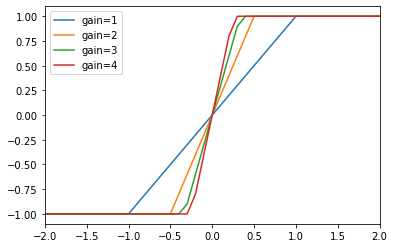

In [31]:
def hard_clipping(x, gain=1):
    y = x * gain
    return np.where(y > 1, 1, np.where(y < -1, -1, y))

for i in [1, 2, 3, 4]:
    plt.plot(x, hard_clipping(x, gain=i), label='gain={}'.format(i))
plt.xlim(-2, 2)
plt.legend()

#### polymonial

In [7]:
def distortion_poly(x, deg=3):
    if deg % 2 != 1:
        raise ValueError('polynomial degree {} must be odd integer'.format(deg))
    return np.where(
        x > 1, (deg - 1) / deg,
        np.where(
            x < -1, -(deg-1)/deg,
            x - x ** deg / deg
        )
    )

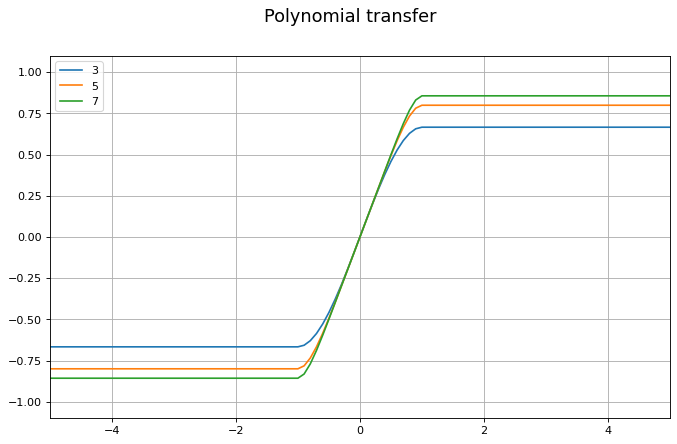

In [8]:
fig = plt.figure(figsize=(10, 6), dpi=80)
fig.suptitle('Polynomial transfer', fontsize=16)
ax = fig.add_subplot(111)
for i in [3, 5, 7]:
    ax.plot(x, distortion_poly(x, i), label=i)
ax.set_xlim(-5, 5)
ax.set_ylim(-1.1, 1.1)
ax.grid(True)
ax.legend()

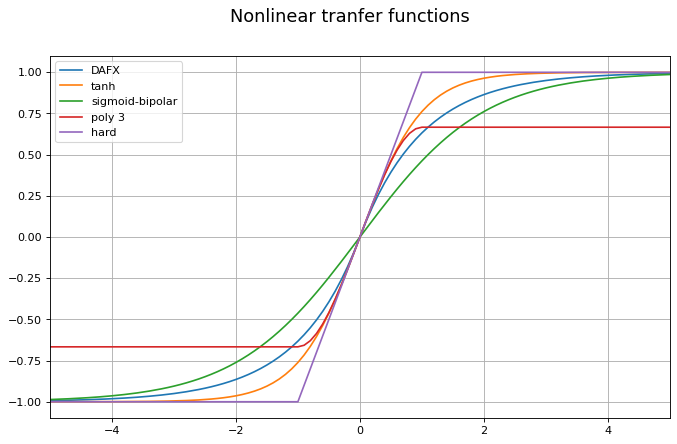

In [9]:
fig = plt.figure(figsize=(10, 6), dpi=80)
fig.suptitle('Nonlinear tranfer functions (gain=1)', fontsize=16)
ax = fig.add_subplot(111)
ax.plot(x, distortion_dafx(x), label='DAFX')
ax.plot(x, np.tanh(x), label='tanh')
ax.plot(x, sigmoid_bipolar(x), label='sigmoid-bipolar')
ax.plot(x, distortion_poly(x, 3), label='poly 3')
ax.plot(x, hard_clipping(x), label='hard')
ax.set_xlim(-5, 5)
ax.grid(True)
ax.legend()

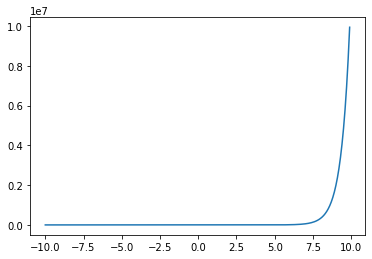

In [10]:
def shockley_diode(x, alpha=1.79, beta=0.2):
    return beta * (np.exp(alpha*x) - 1.0)

plt.plot(x, shockley_diode(x))

### Makeup gain
Investigate how much makeup gain is required for input=1 to give output=1

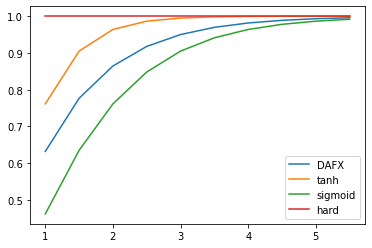

In [53]:
g = np.arange(1, 6, 0.5)
plt.plot(g, distortion_dafx(1, gain=g), label='DAFX')
plt.plot(g, tanh_alt(1, gain=g), label='tanh')
plt.plot(g, sigmoid_bipolar(1, gain=g), label='sigmoid')
plt.plot(g, hard_clipping(1, gain=g), label='hard')
plt.legend()

## Applied distortion

In [11]:
def sine_wave(x, freq, fs):
    return np.sin(2 * np.pi * x * freq / fs)

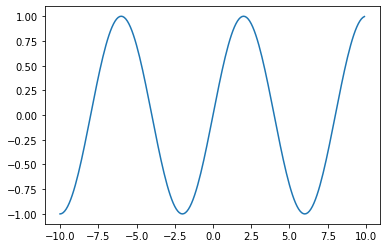

In [16]:
fs = 48000
freq = fs / 8
plt.plot(x, sine_wave(x, freq, fs))

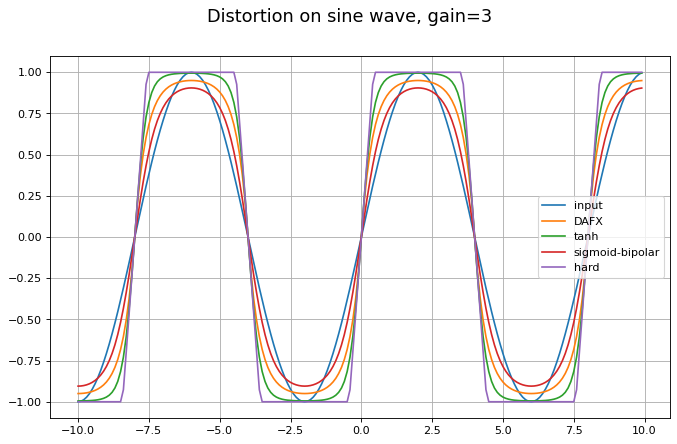

In [51]:
gain = 3
fig = plt.figure(figsize=(10, 6), dpi=80)
fig.suptitle('Distortion on sine wave, gain={}'.format(gain), fontsize=16)
ax = fig.add_subplot(111)
ax.plot(x, sine_wave(x, freq, fs), label='input')
ax.plot(x, distortion_dafx(sine_wave(x, freq, fs), gain=gain), label='DAFX')
ax.plot(x, tanh_alt(sine_wave(x, freq, fs), gain=gain), label='tanh')
ax.plot(x, sigmoid_bipolar(sine_wave(x, freq, fs), gain=gain), label='sigmoid-bipolar')
#ax.plot(x, distortion_poly(x, 3), label='poly 3')
ax.plot(x, hard_clipping(sine_wave(x, freq, fs), gain=gain), label='hard')
#ax.set_xlim(-5, 5)
ax.grid(True)
ax.legend()